<a href="https://colab.research.google.com/github/teploe-odealko/KazanExpress_Junior_DS_test/blob/master/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

После блоков Imports и Data можно сразу перейти в NN - там самое интересное

# Imports

In [2]:
!gdown https://drive.google.com/uc?id=1JiZ4Q791pF-7a85gMea-gfVVcajWg6HD


Downloading...
From: https://drive.google.com/uc?id=1JiZ4Q791pF-7a85gMea-gfVVcajWg6HD
To: /content/KazanExpress_Hiring_Task_Junior_DS.zip
3.66MB [00:00, 114MB/s]


In [3]:
!unzip KazanExpress_Hiring_Task_Junior_DS.zip

Archive:  KazanExpress_Hiring_Task_Junior_DS.zip
  inflating: README.md               
   creating: data/
  inflating: data/categories.csv     
  inflating: data/products.csv       


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from gensim.models import Word2Vec

# from catboost import CatBoostClassifier

#text processing
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
cat = pd.read_csv('/content/data/categories.csv')
prod = pd.read_csv('/content/data/products.csv')

# Data

##Количесво категорий нижнего уровня

In [7]:
len(prod.category_id.unique())

787

##Высота иерархий

In [8]:
cat.category_path.apply(lambda x: len(x.split('.'))).value_counts()

5    715
4    221
3     21
2      2
Name: category_path, dtype: int64

##Добавление промежуточных категорий в таблицу продуктов

In [9]:
cat

,category_id,category_title,category_path
0,13021,Базы и топы,1.10012.10113.13021
1,2740,Полки и подставки,1.10018.10110.12842.2740
2,13182,Салюты,1.10018.10118.10749.13182
3,2864,Ложки для обуви,1.10018.10110.12823.2864
4,14154,Аромабудильники и картриджи,1.10020.10227.14154
...,...,...,...
954,14142,Электроматрасы,1.10018.10049.11300.14142
955,12616,Оттеночные и тонирующие средства,1.10012.10165.11285.12616
956,12741,"Тряпки, салфетки и губки",1.10018.10110.10559.12741
957,13786,Карты памяти и флешки,1.10020.10074.11087.13786


In [10]:
for i, row in cat.iterrows():
    for j, tmp_cat in enumerate(row.category_path.split('.')):
        cat.loc[i,f'category_{j + 1}_level'] = int(tmp_cat)

In [11]:
cat

,category_id,category_title,category_path,category_1_level,category_2_level,category_3_level,category_4_level,category_5_level
0,13021,Базы и топы,1.10012.10113.13021,1.0,10012.0,10113.0,13021.0,NaN
1,2740,Полки и подставки,1.10018.10110.12842.2740,1.0,10018.0,10110.0,12842.0,2740.0
2,13182,Салюты,1.10018.10118.10749.13182,1.0,10018.0,10118.0,10749.0,13182.0
3,2864,Ложки для обуви,1.10018.10110.12823.2864,1.0,10018.0,10110.0,12823.0,2864.0
4,14154,Аромабудильники и картриджи,1.10020.10227.14154,1.0,10020.0,10227.0,14154.0,NaN
...,...,...,...,...,...,...,...,...
954,14142,Электроматрасы,1.10018.10049.11300.14142,1.0,10018.0,10049.0,11300.0,14142.0
955,12616,Оттеночные и тонирующие средства,1.10012.10165.11285.12616,1.0,10012.0,10165.0,11285.0,12616.0
956,12741,"Тряпки, салфетки и губки",1.10018.10110.10559.12741,1.0,10018.0,10110.0,10559.0,12741.0
957,13786,Карты памяти и флешки,1.10020.10074.11087.13786,1.0,10020.0,10074.0,11087.0,13786.0


In [13]:
category_dict = {}
for index, row in cat.iterrows():
    category_id = row['category_path'].split('.')[-1]
    category_dict[int(category_id)] = row['category_path']

In [14]:
prod['full_category'] = prod['category_id'].apply(lambda cat_id: category_dict[cat_id])

In [15]:
prod['category_layer1'] = prod.full_category.apply(lambda full_cat: int(full_cat.split('.')[0]))
prod['category_layer2'] = prod.full_category.apply(lambda full_cat: int(full_cat.split('.')[1]))
prod['category_layer3'] = prod.full_category.apply(lambda full_cat: int(full_cat.split('.')[2]))
prod['category_layer4'] = prod.full_category.apply(lambda full_cat: int(full_cat.split('.')[3]))

In [16]:
def get_5th_level_category(full_cat):
    try:
        return int(full_cat.split('.')[4])
    except IndexError:
        return np.nan

In [17]:
prod['category_layer5'] = prod.full_category.apply(get_5th_level_category)

In [18]:
prod.category_layer5.fillna(0, inplace=True)

In [19]:
prod

,row_number,product_title,category_id,full_category,category_layer1,category_layer2,category_layer3,category_layer4,category_layer5
0,1,Термокружка с животными 350/500 мл,12407,1.10018.10115.10586.12407,1,10018,10115,10586,12407.0
1,2,Пластиковая емкость для хранения круп,12667,1.10018.10115.10992.12667,1,10018,10115,10992,12667.0
2,3,Контейнер с дозатором для хранения круп,13901,1.10018.10115.10992.13901,1,10018,10115,10992,13901.0
3,4,Контейнер для хранения яиц,13674,1.10018.10115.10992.13674,1,10018,10115,10992,13674.0
4,5,Губкодержатель,13254,1.10018.10115.10390.13254,1,10018,10115,10390,13254.0
...,...,...,...,...,...,...,...,...,...
144077,144078,Аэропуффинг двусторонний с кристаллами со смен...,12454,1.10012.10113.12454,1,10012,10113,12454,0.0
144078,144079,Greenconnect / 0.5м / кабель micro usb - usb 2...,12171,1.10020.10044.11281.12171,1,10020,10044,11281,12171.0
144079,144080,Greenconnect / кабель micro usb - usb 2.0 / шн...,12171,1.10020.10044.11281.12171,1,10020,10044,11281,12171.0
144080,144081,"Комплект постельного белья 1,5 спальный бязь",13358,1.10018.10049.10858.13358,1,10018,10049,10858,13358.0


In [20]:
prod.iloc[:,4:].isna().any()

category_layer1    False
category_layer2    False
category_layer3    False
category_layer4    False
category_layer5    False
dtype: bool

## Убираем малочисленные классы

In [21]:
uniq_vals = prod.category_id.value_counts()
more_10_examples_categories = uniq_vals[uniq_vals>10].index
more_10_examples_categories

Int64Index([11937, 13408, 12171, 14241, 14125, 13407, 12604, 12630, 12454,
            11878,
            ...
            11922, 14046, 11830, 11821, 12074, 14265, 12327, 13962, 12436,
            12615],
           dtype='int64', length=607)

In [22]:
prod = prod[prod.category_id.isin(more_10_examples_categories)]

##Предобработка текста заголовков

In [23]:
def preprocess_text(text):
    """Preprocess text into normalised tokens."""
    stop_word_list = nltk.corpus.stopwords.words('russian')
    tokeniser = RegexpTokenizer("[A-Za-zА-Яа-я]+")
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise
    # morph = pymorphy2.MorphAnalyzer()
    # tokens_norm = [morph.parse(t.lower())[0].normal_form for t in tokens]
    # tokens_clean = [t for t in tokens_norm if t not in stop_word_list]
    tokens_lower = [t.lower() for t in tokens]
    tokens_clean = [t for t in tokens_lower if t not in stop_word_list]
    return ' '.join(tokens_clean)

In [24]:
prod['preprocessed'] = prod['product_title'].apply(preprocess_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143359 entries, 0 to 144081
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   row_number       143359 non-null  int64  
 1   product_title    143359 non-null  object 
 2   category_id      143359 non-null  int64  
 3   full_category    143359 non-null  object 
 4   category_layer1  143359 non-null  int64  
 5   category_layer2  143359 non-null  int64  
 6   category_layer3  143359 non-null  int64  
 7   category_layer4  143359 non-null  int64  
 8   category_layer5  143359 non-null  float64
 9   preprocessed     143359 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 12.0+ MB


#Models

In [ ]:
seed = 42
def create_baseline_models():
    """Create list of baseline models."""
    models = []
    models.append(('sgd', SGDClassifier(random_state=seed)))
    # models.append(('mnb', MultinomialNB()))
    # models.append(('random forest', RandomForestClassifier()))
    # models.append(('catboost', CatBoostClassifier()))
    return models
def assess(X, y, models, cv=5, scoring=['accuracy', 'f1_macro', 'f1_weighted']):
    """Provide summary of cross validation results for models."""
    results = pd.DataFrame()
    for name, model in models:
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, 
                                             scoring=scoring))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        results[name] = pd.concat([mean, std], axis=0)
    return results.sort_index()

In [ ]:
models = create_baseline_models()
models

[('sgd', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                l1_ratio=0.15, learning_rate='optimal', loss='hinge',
                max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
                power_t=0.5, random_state=42, shuffle=True, tol=0.001,
                validation_fraction=0.1, verbose=0, warm_start=False))]

# Категории второго уровня

Примерно сбалансированные классы

In [ ]:
prod.category_layer2.hist()

AttributeError: ignored

## Feature generagion

word to vec: dim 100

In [ ]:
w2v_model = Word2Vec(min_count=5,
                     window=2,
                     size=50,
                     sample=6e-5,
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=10,
                     seed=seed)

w2v_model.build_vocab(prod['preprocessed'].apply(lambda x: x.split()), progress_per=1000)
w2v_model.train(prod['preprocessed'].apply(lambda x: x.split()), total_examples=w2v_model.corpus_count, epochs=1, report_delay=1)
w2v_model.wv.most_similar(positive=["кружка"])

[('ванн', 0.9998334050178528),
 ('термометр', 0.9998072981834412),
 ('сувенирная', 0.9997988939285278),
 ('ручная', 0.9997978806495667),
 ('mayer', 0.9997919201850891),
 ('бальзам', 0.9997901320457458),
 ('бомбочка', 0.9997882843017578),
 ('соль', 0.9997879862785339),
 ('температуры', 0.9997875094413757),
 ('е', 0.9997859597206116)]

Усредняем векторы word2veс и получаем вектор предожения

In [ ]:
sent_emb = prod['preprocessed'].apply(
    lambda text:
        np.mean([w2v_model.wv[w] for w in text.split() if w in w2v_model.wv],
                axis=0)
              )
y = prod['category_layer2'][sent_emb.notna()]
X = sent_emb[sent_emb.notna()]
X = np.stack(X)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [ ]:
X.shape

(143994, 50)

In [ ]:
# vectoriser = TfidfVectorizer(token_pattern=r'[A-Za-zА-Яа-я]+', 
#                              min_df=30)
# X_train_tfidf = vectoriser.fit_transform(prod['product_title'])

## Средняя accuracy по кросс валидации ~ 0.96

In [ ]:
%time
results = assess(X, y, models)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [ ]:
results.iloc[4:]

,sgd
test_accuracy_mean,0.958609
test_accuracy_std,0.003656
test_f1_macro_mean,0.957147
test_f1_macro_std,0.003669
test_f1_weighted_mean,0.958614
test_f1_weighted_std,0.003651


# Категории третьего уровня

Так как классы не сбалансированные, лучше смотреть на метрики f1

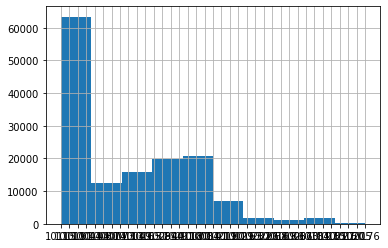

In [ ]:
prod.category_3.hist()

In [ ]:
len(prod.category_3.unique())

37

In [ ]:
y = prod['category_3'][sent_emb.notna()]

##Средняя accuracy по кросс валидации ~ 0.86 & f1_weighted ~ 0.83

In [ ]:
%time
results = assess(X, y, models)

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 24.1 µs


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
results.iloc[4:]

,sgd
test_accuracy_mean,0.842007
test_accuracy_std,0.005717
test_f1_macro_mean,0.579568
test_f1_macro_std,0.009437
test_f1_weighted_mean,0.834853
test_f1_weighted_std,0.005871


## Проверка гипотизы: "Правильное предсказание более высокого уровня поможет при предсказании нижнего"

Добавим категории второго уровня в признаки при предсказании третьего

In [ ]:
level2_categories = prod[sent_emb.notna()].category_2.values

In [ ]:
level2_categories

array(['10018', '10018', '10018', ..., '10020', '10018', '10020'],
      dtype=object)

In [ ]:
y

0         10115
1         10115
2         10115
3         10115
4         10115
          ...  
144077    10113
144078    10044
144079    10044
144080    10049
144081    10044
Name: category_3, Length: 143994, dtype: object

In [ ]:
level2_categories = level2_categories.reshape(-1, 1)

In [ ]:
extended_X = np.hstack([X, level2_categories])

## accuracy 

In [ ]:
%time
results = assess(StandardScaler().fit_transform(extended_X), y, models)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 40.8 µs


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
results.iloc[4:]

,sgd
test_accuracy_mean,0.845987
test_accuracy_std,0.004297
test_f1_macro_mean,0.567095
test_f1_macro_std,0.009733
test_f1_weighted_mean,0.839836
test_f1_weighted_std,0.003585


## catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 31 kB/s 


In [ ]:
from catboost import Pool, CatBoostClassifier

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(extended_X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

cat_features = [50]




train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features)

eval_dataset = Pool(data=X_test,
                    label=y_test,
                    cat_features=cat_features)

# Initialize CatBoostClassifier
model = CatBoostClassifier(
                           learning_rate=0.1,
                           depth=2,
                           loss_function='MultiClass',
                           custom_metric='TotalF1',
                           eval_metric='TotalF1')
# Fit model
model.fit(train_dataset, eval_set=eval_dataset)
# Get predicted classes


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.2568505	test: 0.2557520	best: 0.2557520 (0)	total: 3.64s	remaining: 1h 33s
1:	learn: 0.2583980	test: 0.2571182	best: 0.2571182 (1)	total: 7.17s	remaining: 59m 39s
2:	learn: 0.2840051	test: 0.2825238	best: 0.2825238 (2)	total: 10.8s	remaining: 59m 34s
3:	learn: 0.3440121	test: 0.3408622	best: 0.3408622 (3)	total: 14.2s	remaining: 59m 1s
4:	learn: 0.3441816	test: 0.3419900	best: 0.3419900 (4)	total: 17.7s	remaining: 58m 40s
5:	learn: 0.3829942	test: 0.3797354	best: 0.3797354 (5)	total: 21.2s	remaining: 58m 35s
6:	learn: 0.3896082	test: 0.3871772	best: 0.3871772 (6)	total: 23.8s	remaining: 56m 11s
7:	learn: 0.3948577	test: 0.3920409	best: 0.3920409 (7)	total: 26.3s	remaining: 54m 19s
8:	learn: 0.4033134	test: 0.4000998	best: 0.4000998 (8)	total: 28.8s	remaining: 52m 56s
9:	learn: 0.4086393	test: 0.4065744	best: 0.4065744 (9)	total: 31.4s	remaining: 51m 49s
10:	learn: 0.4192479	test: 0.4171938	best: 0.4171938 (10)	total: 34s	remaining: 50m 54s
11:	learn: 0.4245842	test: 0.42302

# идеи

Можно попробовать


*   Нагенерировать признаки трансформерными сетками (например Bertом), fasttextом и объеденить с признаками  w2v. 

*   Использовать разные классификаторы, но даже sgdclassifier дает неплохой результат без подбора гиперпараметров.

*   Подобрать гиперпараметры
*   Использовать полученные результаты предсказаний высоких уровней для предсказания более низких






#NN approach

## 2 уровень категорий acc ~ 0.98; f1_macro ~ 0.98

In [26]:
!pip install pytorch-lightning  

     |████████████████████████████████| 922 kB 5.1 MB/s 
     |████████████████████████████████| 636 kB 45.9 MB/s 
     |████████████████████████████████| 282 kB 42.6 MB/s 
     |████████████████████████████████| 829 kB 38.2 MB/s 
     |████████████████████████████████| 119 kB 41.8 MB/s 
     |████████████████████████████████| 1.3 MB 36.1 MB/s 
     |████████████████████████████████| 294 kB 48.2 MB/s 
     |████████████████████████████████| 142 kB 48.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=87beb62c9816b11a70c03d6fe1243529fe593d1d711081c43e5fc8311bdc3e83
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [27]:
input_size = 100
seed = 42


w2v_model = Word2Vec(min_count=1,
                     window=2,
                     size=input_size,
                     sample=6e-5,
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=10,
                     seed=seed)

w2v_model.build_vocab(prod['preprocessed'].apply(lambda x: x.split()), progress_per=1000)
w2v_model.train(prod['preprocessed'].apply(lambda x: x.split()), total_examples=w2v_model.corpus_count, epochs=60, report_delay=1)
sent_emb = prod['preprocessed'].apply(
    lambda text:
        np.mean([w2v_model.wv[w] for w in text.split() if w in w2v_model.wv],
                axis=0)
            )
y_layer2 = prod['category_layer2'][sent_emb.notna()].values
y_layer3 = prod['category_layer3'][sent_emb.notna()].values
y_layer4 = prod['category_layer4'][sent_emb.notna()].values
y_layer5 = prod['category_layer5'][sent_emb.notna()].values
X = sent_emb[sent_emb.notna()]
X = np.stack(X)
print(len(sent_emb), len(X), len(y_layer2))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


143359 143358 143358


In [28]:
from torch.utils.data import TensorDataset, DataLoader
import torch
def make_datasets(X: np.ndarray, y: np.ndarray, y_strat: np.ndarray):
    X_train, X_test, y_strat_train, _ = train_test_split(X, y_strat, test_size=0.2, random_state=42, stratify=y_strat)
    X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=42, stratify=y_strat_train)

    y_train, y_test = train_test_split(y, test_size=0.2, random_state=42, stratify=y_strat)
    y_train, y_val = train_test_split(y_train, test_size=0.25, random_state=42, stratify=y_strat_train)


    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    return train_dataset, test_dataset, val_dataset

In [29]:
import torch 
  
from torch import nn 
import pytorch_lightning as pl 
import torch.nn.functional as F 
from torchvision import datasets, transforms
from torch.optim import SGD 
from torch.utils.data import random_split, DataLoader 
from sklearn.metrics import accuracy_score
pl.utilities.seed.seed_everything(seed=42)

class ModelLayer2(pl.LightningModule): 
    def __init__(self): 
        super().__init__() 

        self.fc1 = nn.Linear(100, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128) 
        self.fc3 = nn.Linear(128, 3) 
        # self.out = nn.Linear(128, len(np.unique(y))) 
        self.lr = 0.01
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, x):
        batch_size, _, = x.size() 
        x = x.view(batch_size, -1) 
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x)) 
        return self.fc3(x) 
    
    def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
        self.eval()
        return self(batch)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr = self.lr) 
    
    def training_step(self, train_batch, batch_idx): 
        x, y = train_batch 
        logits = self.forward(x) 
        loss = self.loss(logits, y) 
        return loss 
    
    def validation_step(self, valid_batch, batch_idx): 
        x, y = valid_batch 
        logits = self.forward(x)
        loss = self.loss(logits, y)

        return {'pred': logits,'target': y}

    def validation_epoch_end(self, outputs):
        y = torch.cat([out['target'] for out in outputs])
        y_hat = torch.cat([out['pred'] for out in outputs])
        prec, recall, f1_macro, _ = precision_recall_fscore_support(
            y.cpu(), y_hat.argmax(axis=1).cpu(), average='macro'
            )
        prec_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
            y.cpu(), y_hat.argmax(axis=1).cpu(), average='weighted'
            )
        
        acc = accuracy_score(y, y_hat.argmax(axis=1).cpu())
        self.log('val_prec', prec, prog_bar=True)
        self.log('val_recall', recall, prog_bar=True)
        self.log('val_f1_macro', f1_macro, prog_bar=True)
        self.log('val_f1_weighted', f1_weighted, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, valid_batch, batch_idx): 
        x, y = valid_batch 
        logits = self.forward(x)
        loss = self.loss(logits, y)

        return {'pred': logits,'target': y}

    def test_epoch_end(self, outputs):
        y = torch.cat([out['target'] for out in outputs])
        y_hat = torch.cat([out['pred'] for out in outputs])
        prec, recall, f1_macro, _ = precision_recall_fscore_support(
            y.cpu(), y_hat.argmax(axis=1).cpu(), average='macro'
            )
        prec_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
            y.cpu(), y_hat.argmax(axis=1).cpu(), average='weighted'
            )
        
        acc = accuracy_score(y, y_hat.argmax(axis=1).cpu())
        self.log('test_prec', prec, prog_bar=True)
        self.log('test_recall', recall, prog_bar=True)
        self.log('test_f1_macro', f1_macro, prog_bar=True)
        self.log('test_f1_weighted', f1_weighted, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
  
class ProductsCategoryDataModule(pl.LightningDataModule):
    def __init__(self, X, y, y_strat):
        super().__init__()

        self.X = X
        self.y = y
        self.y_strat = y_strat
        self.batch_size = 32
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
  
    def prepare_data(self):
        pass
        
    def setup(self, stage=None):
        self.train_data, self.valid_data, self.test_data = make_datasets(self.X, self.y, self.y_strat)

  
    def train_dataloader(self):
                return DataLoader(self.train_data, 
                          batch_size = self.batch_size)
  
    def val_dataloader(self):
                return DataLoader(self.valid_data,
                          batch_size = self.batch_size)
  
    def test_dataloader(self):
                return DataLoader(self.test_data,
                          batch_size = self.batch_size)

Global seed set to 42


In [30]:
layer2_label_mapping = dict(zip(np.unique(y_layer2), list(range(len(np.unique(y_layer2))))))
def map_class_id(y):
    return layer2_label_mapping[y]
y_layer2_mapped = np.array(list(map(map_class_id, y_layer2)))

In [31]:
# model_layer_2 = ModelLayer2() 


In [ ]:
model_layer_2 = ModelLayer2() 
data_level_2 = ProductsCategoryDataModule(X, y_layer2_mapped, y_layer4) 
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model_layer_2, data_level_2)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1295: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"

  | Name | Type             | Params
------------------------------------------
0 | fc1  | Linear           | 25.9 K
1 | bn1  | BatchNorm1d      | 512   
2 | fc2  | Linear           | 32.9 K
3 | fc3  | Linear           | 387   
4 | loss | CrossEntropyLoss | 0     
------------------------------------------
59.7 K    Trainable params
0         Non-trainable params
59.7 K    Total params
0.239     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# trainer.save_hyperparameters()
trainer.save_checkpoint("layer2.ckpt")

 ## 3 уровень категорий acc ~ 0.87; f1_macro ~ 0.5

In [ ]:

layer3_label_mapping = dict(zip(np.unique(y_layer3), list(range(len(np.unique(y_layer3))))))
def map_class_id(y):
    return layer3_label_mapping[y]
y_layer3_mapped = np.array(list(map(map_class_id, y_layer3)))

In [ ]:
len(np.unique(y_layer3_mapped))

In [ ]:
class ModelLayer3(ModelLayer2): 
    def __init__(self): 
        super().__init__()
        # self.fc1.freeze() 
        # self.fc2.freeze() 
        # self.fc3.freeze() 
        self.fc4 = nn.Linear(3, 64)
        self.fc5 = nn.Linear(64, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 36)

    def forward(self, x):
        batch_size, _, = x.size() 
        x = x.view(batch_size, -1) 
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.bn2(x)
        x = F.relu(self.fc6(x))
        return self.fc7(x)

    # def configure_optimizers(self):
    #     return torch.optim.SGD(self.parameters(), lr = 0.1)

In [ ]:
model_layer_3 = ModelLayer3() 
data_level_3 = ProductsCategoryDataModule(X, y_layer3_mapped, y_layer4)
trainer = pl.Trainer(max_epochs=10)

In [ ]:
model_layer_3.load_from_checkpoint('layer2.ckpt', strict=False)

In [ ]:
# model_layer_3.fc1.requires_grad = False
# model_layer_3.fc2.requires_grad = False
# model_layer_3.fc3.requires_grad = False


In [40]:
trainer.fit(model_layer_3, data_level_2)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name | Type             | Params
------------------------------------------
0 | fc1  | Linear           | 25.9 K
1 | bn1  | BatchNorm1d      | 512   
2 | fc2  | Linear           | 32.9 K
3 | fc3  | Linear           | 387   
4 | loss | CrossEntropyLoss | 0     
5 | fc4  | Linear           | 256   
6 | fc5  | Linear           | 16.6 K
7 | bn2  | BatchNorm1d      | 512   
8 | fc6  | Linear           | 32.9 K
9 | fc7  | Linear           | 4.6 K 
------------------------------------------
114 K     Trainable params
0         Non-trainable params
114 K     Total params
0.458     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


In [41]:
trainer.save_checkpoint("layer3.ckpt")

In [42]:
trainer.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9840262532234192,
 'test_f1_macro': 0.9834669232368469,
 'test_f1_weighted': 0.9840183854103088,
 'test_prec': 0.9833955764770508,
 'test_recall': 0.9835543632507324}
--------------------------------------------------------------------------------


[{'test_acc': 0.9840262532234192,
  'test_f1_macro': 0.9834669232368469,
  'test_f1_weighted': 0.9840183854103088,
  'test_prec': 0.9833955764770508,
  'test_recall': 0.9835543632507324}]

## 4 уровень категорий acc ~ 0.77; f1_macro ~ 0.4

In [43]:
layer4_label_mapping = dict(zip(np.unique(y_layer4), list(range(len(np.unique(y_layer4))))))
def map_class_id(y):
    return layer4_label_mapping[y]
y_layer4_mapped = np.array(list(map(map_class_id, y_layer4)))

In [44]:
len(np.unique(y_layer4_mapped))

211

In [45]:
class ModelLayer4(ModelLayer3): 
    def __init__(self): 
        super().__init__()

        self.fc8 = nn.Linear(36, 64)
        self.fc9 = nn.Linear(64, 256)
        self.dr1 = nn.Dropout(0.5)
        self.fc10 = nn.Linear(256, 211)

    def forward(self, x):
        batch_size, _, = x.size() 
        x = x.view(batch_size, -1) 
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x)) 
        x = F.relu(self.fc4(x)) 
        x = F.relu(self.fc5(x)) 
        x = F.relu(self.fc6(x)) 
        x = F.relu(self.fc7(x)) 
        x = F.relu(self.fc8(x)) 
        x = F.relu(self.fc9(x))
        # x = self.dr1(x)
        return self.fc10(x)

In [46]:
model_layer_4 = ModelLayer4()
data_level_4 = ProductsCategoryDataModule(X, y_layer4_mapped, y_layer4)
trainer = pl.Trainer(max_epochs=10)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1295: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"


In [58]:
model_layer_4.load_from_checkpoint('layer3.ckpt', strict=False)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/saving.py:206: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['fc8.weight', 'fc8.bias', 'fc9.weight', 'fc9.bias', 'fc10.weight', 'fc10.bias']
  f"Found keys that are in the model state dict but not in the checkpoint: {keys.missing_keys}"


ModelLayer4(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (loss): CrossEntropyLoss()
  (fc4): Linear(in_features=3, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=256, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=36, bias=True)
  (fc8): Linear(in_features=36, out_features=64, bias=True)
  (fc9): Linear(in_features=64, out_features=256, bias=True)
  (dr1): Dropout(p=0.5, inplace=False)
  (fc10): Linear(in_features=256, out_features=211, bias=True)
)

In [59]:
trainer.fit(model_layer_4, data_level_4)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

   | Name | Type             | Params
-------------------------------------------
0  | fc1  | Linear           | 25.9 K
1  | bn1  | BatchNorm1d      | 512   
2  | fc2  | Linear           | 32.9 K
3  | fc3  | Linear           | 387   
4  | loss | CrossEntropyLoss | 0     
5  | fc4  | Linear           | 256   
6  | fc5  | Linear           | 16.6 K
7  | bn2  | BatchNorm1d      | 512   
8  | fc6  | Linear           | 32.9 K
9  | fc7  | Linear           | 4.6 K 
10 | fc8  | Linear           | 2.4 K 
11 | fc9  | Linear           | 16.6 K
12 | dr1  | Dropout          | 0     
13 | fc10 | Linear           | 54.2 K
-------------------------------------------
187 K    

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


In [60]:
trainer.save_checkpoint("layer4.ckpt")

In [61]:
trainer.test()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7746233344078064,
 'test_f1_macro': 0.406159907579422,
 'test_f1_weighted': 0.7673935294151306,
 'test_prec': 0.41976943612098694,
 'test_recall': 0.41609564423561096}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


[{'test_acc': 0.7746233344078064,
  'test_f1_macro': 0.406159907579422,
  'test_f1_weighted': 0.7673935294151306,
  'test_prec': 0.41976943612098694,
  'test_recall': 0.41609564423561096}]

## 5 уровень категорий acc ~ ; f1_macro ~ 

In [123]:
layer5_label_mapping = dict(zip(np.unique(y_layer5), list(range(len(np.unique(y_layer5))))))
def map_class_id(y):
    return layer5_label_mapping[y]
y_layer5_mapped = np.array(list(map(map_class_id, y_layer5)))

In [124]:
y_layer5_mapped

array([193, 235, 414, ..., 147, 339,   0])

In [125]:
len(np.unique(y_layer5_mapped))

481

In [126]:
class ModelLayer5(ModelLayer4): 
    def __init__(self): 
        super().__init__()

        self.fc11 = nn.Linear(211, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc12 = nn.Linear(256, 512)
        self.fc13 = nn.Linear(512, 481)

    def forward(self, x):
        batch_size, _, = x.size() 
        x = x.view(batch_size, -1) 
        x = F.relu(self.fc1(x)) 
        x = self.bn1(x)
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x)) 
        x = F.relu(self.fc4(x)) 
        x = F.relu(self.fc5(x)) 
        x = self.bn2(x)
        x = F.relu(self.fc6(x)) 
        x = F.relu(self.fc7(x)) 
        x = F.relu(self.fc8(x)) 
        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))
        x = F.relu(self.fc11(x))
        x = self.bn3(x)
        x = F.relu(self.fc12(x))
        # x = self.dr1(x)
        return self.fc13(x)

In [127]:
model_layer_5 = ModelLayer5()
data_level_5 = ProductsCategoryDataModule(X, y_layer5_mapped, y_layer5)
trainer = pl.Trainer()
model_layer_5.load_from_checkpoint('layer4.ckpt', strict=False)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1295: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/saving.py:206: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['fc11.weight', 'fc11.bias', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'fc12.weight', 'fc12.bias', 'fc13.weight', 'fc13.bias']
  f"Found keys that are in the model state dict but not in the checkpoint: {keys.missing_keys}"


ModelLayer5(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (loss): CrossEntropyLoss()
  (fc4): Linear(in_features=3, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=256, out_features=128, bias=True)
  (fc7): Linear(in_features=128, out_features=36, bias=True)
  (fc8): Linear(in_features=36, out_features=64, bias=True)
  (fc9): Linear(in_features=64, out_features=256, bias=True)
  (dr1): Dropout(p=0.5, inplace=False)
  (fc10): Linear(in_features=256, out_features=211, bias=True)
  (fc11): Linear(in_features=211, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, t

In [149]:
trainer.fit(model_layer_5, data_level_5)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

   | Name | Type             | Params
-------------------------------------------
0  | fc1  | Linear           | 25.9 K
1  | bn1  | BatchNorm1d      | 512   
2  | fc2  | Linear           | 32.9 K
3  | fc3  | Linear           | 387   
4  | loss | CrossEntropyLoss | 0     
5  | fc4  | Linear           | 256   
6  | fc5  | Linear           | 16.6 K
7  | bn2  | BatchNorm1d      | 512   
8  | fc6  | Linear           | 32.9 K
9  | fc7  | Linear           | 4.6 K 
10 | fc8  | Linear           | 2.4 K 
11 | fc9  | Linear           | 16.6 K
12 | dr1  | Dropout          | 0     
13 | fc10 | Linear           | 54.2 K
14 | fc11 | Linear           | 54.3 K
15 | bn3  | Bat

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Global seed set to 42


Training: 451it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


In [150]:
trainer.test()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6670619249343872,
 'test_f1_macro': 0.1523091048002243,
 'test_f1_weighted': 0.6233463883399963,
 'test_prec': 0.16165855526924133,
 'test_recall': 0.1719849705696106}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


[{'test_acc': 0.6670619249343872,
  'test_f1_macro': 0.1523091048002243,
  'test_f1_weighted': 0.6233463883399963,
  'test_prec': 0.16165855526924133,
  'test_recall': 0.1719849705696106}]

In [151]:
trainer.save_checkpoint("layer5.ckpt")

#Pipelining

In [133]:
from sklearn.pipeline import Pipeline

In [132]:
layer5_label_mapping_inv = {v: int(k) for k, v in layer5_label_mapping.items()}
layer4_label_mapping_inv = {v: int(k) for k, v in layer4_label_mapping.items()}

In [143]:
class NNModel():
    def __init__(self,
                 model_level_4,
                 model_level_5,
                 mapping_level_4,
                 mapping_level_5,
                 category_name_df):
        self.model_level_4 = model_level_4
        self.model_level_5 = model_level_5
        self.mapping_level_4 = mapping_level_4
        self.mapping_level_5 = mapping_level_5
        self.cat = category_name_df
    def fit():
        pass
    def predict(self, x):
        x = torch.Tensor(x).reshape(1, -1)

        self.model_level_5.eval()
        y_hat = int(self.model_level_5(x)[0].argmax().numpy())
        category_id = self.mapping_level_5[y_hat]
        if category_id == 0:
            y_hat = int(self.model_level_4(x)[0].argmax().numpy())
            category_id = self.mapping_level_4[y_hat]

        category_5_level = self.cat[self.cat['category_5_level'] == category_id]
        if (len(category_5_level) != 0):
            category_name = category_5_level.category_title.iloc[0]
        else:
            category_name = self.cat[self.cat['category_4_level'] == category_id].category_title.iloc[0]

        return {'category_id' : category_id, 'category_name': category_name}


In [144]:
class Vectorizer():
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
    def preprocess_text(self, text):
        """Preprocess text into normalised tokens."""
        stop_word_list = nltk.corpus.stopwords.words('russian')
        tokeniser = RegexpTokenizer("[A-Za-zА-Яа-я]+")
        tokens = tokeniser.tokenize(text)
        
        # Lowercase and lemmatise
        # morph = pymorphy2.MorphAnalyzer()
        # tokens_norm = [morph.parse(t.lower())[0].normal_form for t in tokens]
        # tokens_clean = [t for t in tokens_norm if t not in stop_word_list]
        tokens_lower = [t.lower() for t in tokens]
        tokens_clean = [t for t in tokens_lower if t not in stop_word_list]
        return ' '.join(tokens_clean)

    def vectorize(self, text):
        word_embs = [self.w2v_model.wv[w] for w in text.split() if w in self.w2v_model.wv]
        if (len(word_embs) > 0):
            return np.mean(word_embs, axis=0)
        return np.zeros(input_size)


    def fit():
        pass
        
    def transform(self, x):
        preprocessed = self.preprocess_text(x)
        # print(self.w2v_model.wv[preprocessed])
        features_x = self.vectorize(preprocessed)
        return features_x

In [152]:
steps = [('vectorizer', Vectorizer(w2v_model)),
              ('model1', NNModel(model_layer_4, model_layer_5,
                                layer4_label_mapping_inv, layer5_label_mapping_inv, cat))
              ]
pipe = Pipeline(steps)
pipe

Pipeline(memory=None,
         steps=[('vectorizer', <__main__.Vectorizer object at 0x7f7b5f7fd590>),
                ('model1', <__main__.NNModel object at 0x7f7b5f7fd4d0>)],
         verbose=False)

In [158]:
pipe.predict('беспроводного зарядного устройства')

{'category_id': 2804, 'category_name': 'Прочая электротехника'}

In [159]:
import joblib
joblib.dump(pipe, '/content/drive/MyDrive/models/model.joblib')

['/content/drive/MyDrive/models/model.joblib']